# PMDARIMA & SKTIME TUTORIAL

<b>It is preferable to have a basic understanding of traditional timeseries modelling before to jump onto this tutorial.</b>

The purpose of this tutorail is to introduce the PMDARIMA & Sktime libraries to those who are unware of their existence. Those two are fantastic python machine learning libraries that ease timeseries manipulation and forecasting by using the standard sklearn methodology as opposed to what the Statmodels module offers. Another thing that I love with the PMDARIMA is the auto_arima that allow to deviate from the acf & pac plots to determine your arima parameteres and that is usually  a headache.
In this tutorial I will use the shampoo dataset.

In [1]:
import pandas as pd
%pylab inline
import pmdarima
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import sktime
from pandas import Series
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.compose import ReducedRegressionForecaster
from sktime.performance_metrics.forecasting import smape_loss
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

Populating the interactive namespace from numpy and matplotlib


In [2]:
#let's read  this dataset see what it looks like.
ts= pd.read_csv('shampoo.csv')
ts.shape

(36, 2)

In [3]:
ts.head()

,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


In [4]:
# changing the date format 
ts['Month']= ts['Month'].apply(lambda x: '199'+ x)


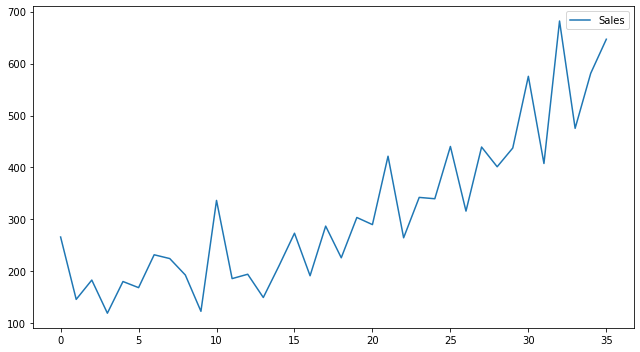

In [5]:
# lets plot the 
ts.plot(figsize=(9,5));
plt.tight_layout()

In [6]:
# changing the month column
ts['Month']=pd.to_datetime(ts['Month'], format='%Y/%m')

In [7]:
ts.set_index('Month', inplace=True)

In [8]:
# a look of how the new dataset look like
ts.head()

,Sales
Month,
1991-01-01,266.0
1991-02-01,145.9
1991-03-01,183.1
1991-04-01,119.3
1991-05-01,180.3


In [9]:
ts.tail()

,Sales
Month,
1993-08-01,407.6
1993-09-01,682.0
1993-10-01,475.3
1993-11-01,581.3
1993-12-01,646.9


In [10]:
df=ts.copy()

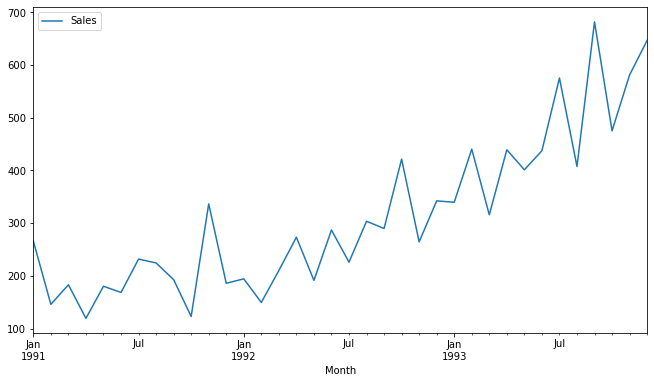

In [11]:
# ploting with the month.
ts.plot(figsize=(11,6));

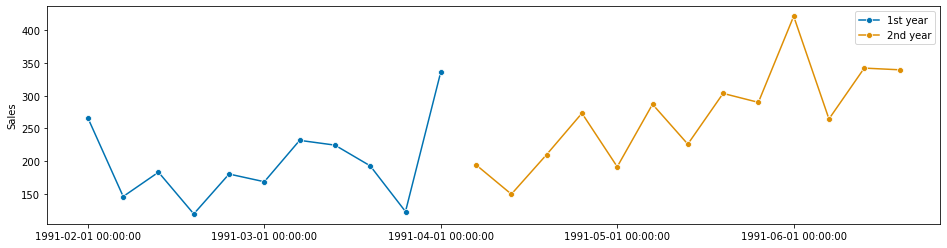

In [12]:
# let's plot using the sktime
from sktime.utils.plotting import plot_series as ps

ps(ts['Sales'][:11],ts['Sales'][12:25], labels=['1st year', '2nd year']);

# 1-USING STATMODELS & ARIMA

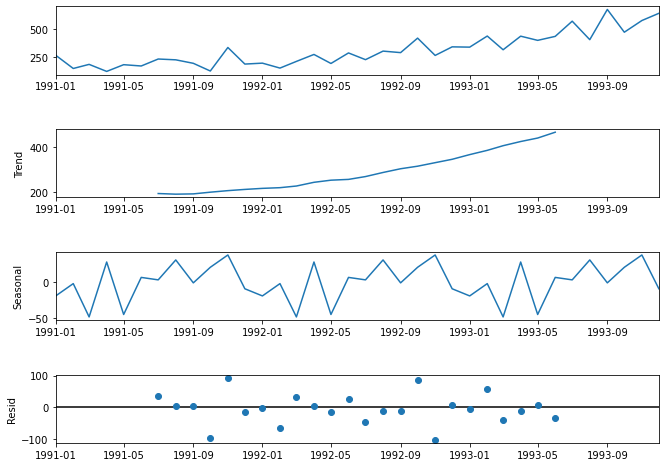

In [13]:
decomp=seasonal_decompose(ts)
fig= decomp.plot()
fig.set_size_inches(10,7)

We now can clearly see some seasonality of this data set which was not to clearly obvious especially for those that are not used to seasonal dataset. I always strongly recommend this plot. It is without a doubt one of the most important plot in timeseries modelling.

<b>Testing Stationality</b>

Looking at the data, it is pretty clear that there is no stationary. However, in some cases eyes can be very deceiving. The Dick fUlher test is always a good practice to test if your data is stationary or not.

In [14]:
def stationarity_test(timeseries):
    print('AdFulher Stationarity results: ')
    print('')
    results=adfuller(timeseries, autolag='AIC')
    labels=['Test Statistics', 'p-value','Numb of Lags', 'Numb of observations used']
    
    for value,label in zip(results, labels):
        print (label+ ' : '+ str(value))
    
    if results[1]<=0.05:
        print ('Strong evidence against null hypothesis')
        print ('reject the null hypothesis, your data is stationary')
    else:
        print ('fail to reject the null hypothesis, data not stationary')
        

In [15]:
stationarity_test(ts['Sales'])

AdFulher Stationarity results: 

Test Statistics : 3.0601420836411806
p-value : 1.0
Numb of Lags : 10
Numb of observations used : 25
fail to reject the null hypothesis, data not stationary


In [16]:
ts.reset_index(drop='Month', inplace=True)

As expected this timeseries is <b>not stationary (p-value > 0.05)</b>. But you have paid attention, you'd have  seen it in the previous plot (decomposition plot). This test is only done for the tutorial purposes. Now let's make this data stationary. If you are a new to timeseries analysis and you are wondering if that is necessary, the answer is No, <b>it's Compulsory</b>

In [17]:
ts['diff']=ts['Sales'] - ts['Sales'].shift(1)

In [18]:
stationarity_test(ts['diff'].dropna())

AdFulher Stationarity results: 

Test Statistics : -7.249074055553854
p-value : 1.7998574141687034e-10
Numb of Lags : 1
Numb of observations used : 33
Strong evidence against null hypothesis
reject the null hypothesis, your data is stationary


There are others methods to make your data stationary (other than the Differencing used in here) such as 
transformations (e.g: log transformation). Personally, I like using the differcing method as it tends to get me there much faster. 

In [19]:
# Remember there is some seasonality here:

ts['Season']= ts['Sales'] - ts['Sales'].shift(12)

In [20]:
stationarity_test(ts['Season'].dropna())

AdFulher Stationarity results: 

Test Statistics : -0.04561553414249077
p-value : 0.9545931714075298
Numb of Lags : 6
Numb of observations used : 17
fail to reject the null hypothesis, data not stationary


This is still not enough to detrend the data. Let's try something else as we are already convinced that the seasonality is one year.

In [21]:
ts['Season']=ts['diff'] - ts['diff'].shift(12)

In [22]:
stationarity_test(ts['Season'].dropna())

AdFulher Stationarity results: 

Test Statistics : -6.356373983478847
p-value : 2.5368941168673004e-08
Numb of Lags : 5
Numb of observations used : 17
Strong evidence against null hypothesis
reject the null hypothesis, your data is stationary


<b>Now we are good. GOOD TO GO</b>

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

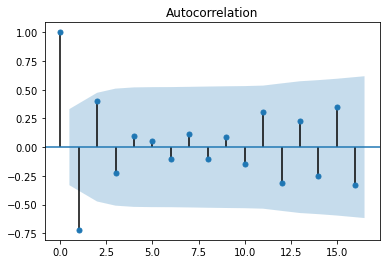

In [24]:
diff_acf=plot_acf(ts['diff'].dropna())


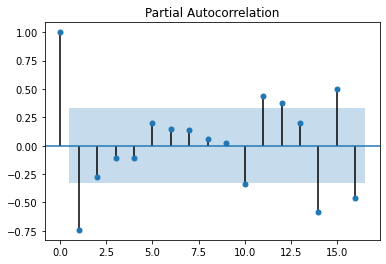

In [25]:
diff_pacf=plot_pacf(ts['diff'].dropna())

In [26]:
arima_mod=ARIMA(ts['Sales'], order=(1,1,1))

results=arima_mod.fit()

In [27]:
print (results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -200.391
Date:                Sat, 19 Dec 2020   AIC                            406.782
Time:                        12:57:09   BIC                            411.448
Sample:                             0   HQIC                           408.393
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6003      0.201     -2.980      0.003      -0.995      -0.205
ma.L1         -0.2756      0.267     -1.033      0.302      -0.799       0.248
sigma2      5382.0425   1386.817      3.881      0.0

A seasonal Arima was not used due to lack of data. Again, the purpose of this show those new library and their
capabilities.

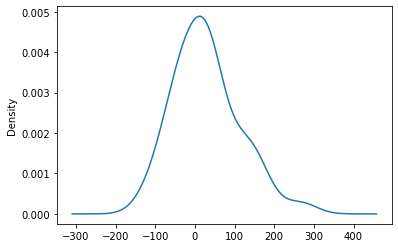

In [28]:
# plotting the residuals

results.resid.plot(kind='kde');

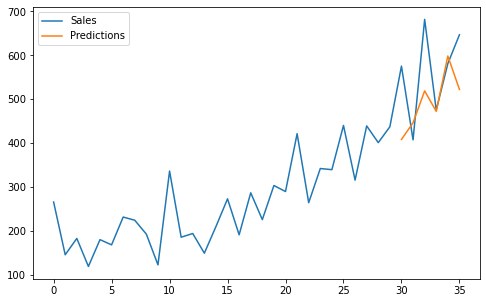

In [29]:
# Visualising the model

ts['Predictions']= results.predict(start=30, end=36)
ts[['Sales', 'Predictions']].plot(figsize=(8,5));

It does not look to pretty; Remember we do not have a forecast on future dates yet, we have a model. 
In order to have a forecast we need to generate *x amount of future dates*, add those dates to the current dataframe (concatenation) then we will able to forecast on those dates. **TOO LONG** .<br> Now let's have a look at the pmdarima libraries.

In [30]:
import warnings
warnings.filterwarnings('ignore')

# building the Arima with pmdarima (trace is used for demonstration purposes)
fit_pmdarima=auto_arima(ts['Sales'],trace=True,suppress_warnings=True)

print(fit_pmdarima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=430.873, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=405.977, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=408.967, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=429.229, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=403.573, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=404.633, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=404.226, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=402.407, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=401.463, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best 

We have a better model :). However, there was probably another way to find to find this order. 
That consist of computing all the possible combinations of p d and q and selecting the ones that has the lower AIC. This method is usually used by the non-instuitionists. Great method by the way

In [31]:
train= df['Sales'][:26]
test=df['Sales'][26:]

In [32]:
# fitting the model using statsmodels 
model=ARIMA(train,order=(1,1,2))
model=model.fit()

print (model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   26
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -139.914
Date:                Sat, 19 Dec 2020   AIC                            287.828
Time:                        12:57:11   BIC                            292.704
Sample:                    01-01-1991   HQIC                           289.180
                         - 02-01-1993                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8753      0.260     -3.367      0.001      -1.385      -0.366
ma.L1          0.0940      0.409      0.230      0.818      -0.708       0.896
ma.L2         -0.3511      0.348     -1.008      0.3

Much better, but now let's see what we have with the test set

In [33]:
start=len(train)
end=len(train)+len(test)-1

preds=model.predict(start=start, end=end, type='levels')

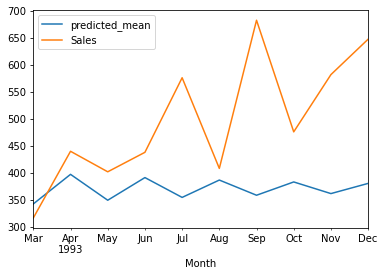

In [34]:
preds.plot(legend=True)
test.plot(legend= True);

In [35]:
from sktime.forecasting.model_selection import temporal_train_test_split
y_train, y_test= temporal_train_test_split(ts['Sales'],test_size=10)

In [36]:
# definijng the forecast horizon
fh=ForecastingHorizon(y_test.index,is_relative=False)

In [37]:
nv_forecaster=NaiveForecaster(strategy='last')

nv_forecaster.fit(y_train)

NaiveForecaster()

In [38]:
y_pred=nv_forecaster.predict(fh)

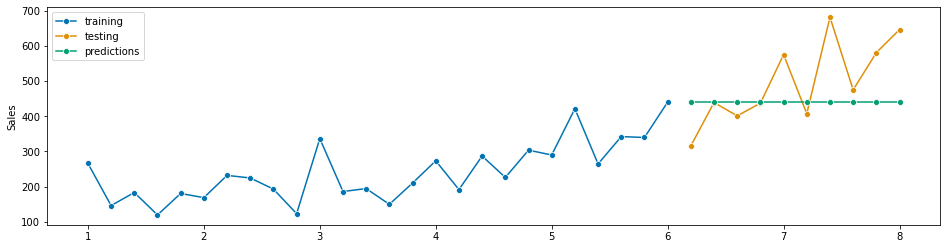

In [39]:
ps(y_train, y_test, y_pred, labels=['training', 'testing', 'predictions']);

In [40]:
# let's try  some exponential smoothing techniques
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

Looking at the graph we can clearly see some form of trend but no clear seasonality, that is why the technique used here would be a 
<b>Double Expenontial Smoothing</b> with multiplicative method. I could have used the additive method I just sense otherwise.

In [41]:
smooth_exp=ExponentialSmoothing(trend='mul', seasonal=None)

# training the model 
smooth_exp.fit(y_train)

ExponentialSmoothing(trend='mul')

In [42]:
# predictions
smooth_preds=smooth_exp.predict(fh)

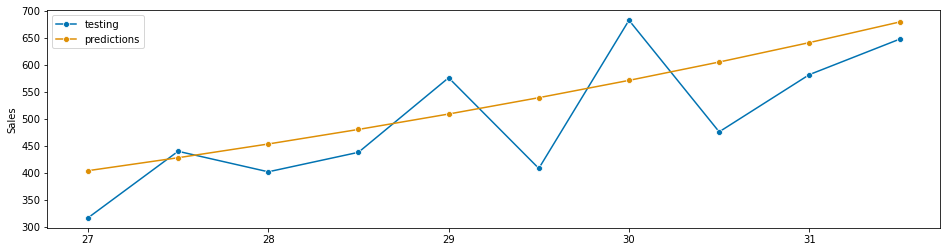

In [43]:
ps( y_test, smooth_preds, labels=['testing','predictions']);

In [44]:
print ('Double Exp smoothing loss is: ', smape_loss(y_test,smooth_preds))

Double Exp smoothing loss is:  0.14469058412539013


In [45]:
# lets try to add some triple Exponential Smothing by seasonality to it 
smooth_exp=ExponentialSmoothing(trend='mul', seasonal='mul', sp=3)
smooth_exp.fit(y_train)

ExponentialSmoothing(seasonal='mul', sp=3, trend='mul')

In [46]:
triple_exp=smooth_exp.predict(fh)

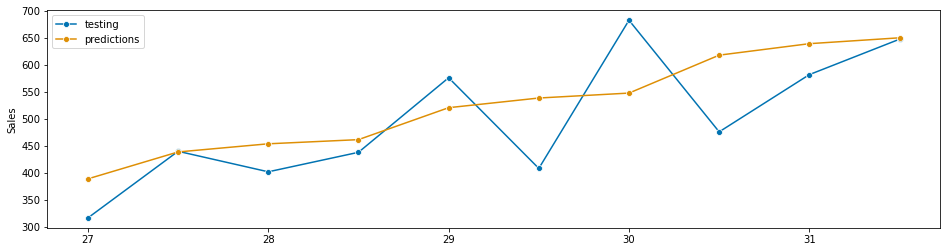

In [47]:
ps(y_test, triple_exp, labels=['testing', 'predictions']);

In [48]:
print ('Triple Exp smoothing loss is: ', smape_loss(y_test,triple_exp))

Triple Exp smoothing loss is:  0.13362635874290993


Great! to be honest I did not expect that. The triple Exponential Smoothing did a good job;  by a little but better
I have only noticed it when I printed the SMAPE (Symetric, Mean, Absolute, Percentage, Error) loss. hi hi :)

# SKtime AutoARIMA

The sklearn package alllows us to use the auto regressive integrated moving average model. So why is it called
Auto-Arima?? Well, this is because just like in pmdarima. The Auto-Arima let you automatically find the best parameters for your arima model. Here is a glimpse of it:

In [49]:
from sktime.forecasting.arima import AutoARIMA

In [50]:
forecaster=AutoARIMA(start_p=1,max_p=4, d=1, start_q=1,max_q=4)

forecaster.fit(y_train)

AutoARIMA(d=1, max_p=4, max_q=4, start_p=1, start_q=1)

In [51]:
y_pred=forecaster.predict(fh)

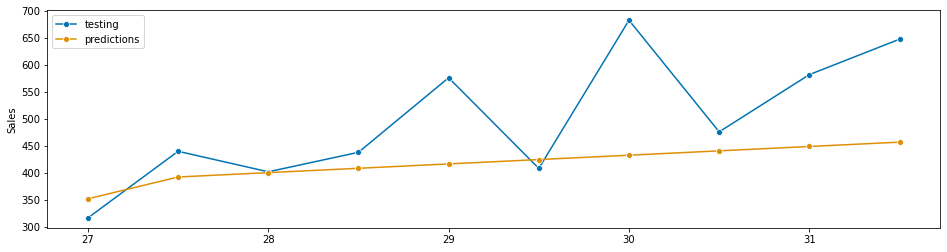

In [52]:
ps(y_test,y_pred,labels=['testing', 'predictions']);

# USING REGRESIONS TECHNIQUES

In [53]:
linreg= LinearRegression()
randFor= RandomForestRegressor()
knnreg= KNeighborsRegressor(n_neighbors=2)

reg_list= [linreg,randFor,knnreg]

In [54]:
for i in reg_list:
    forecaster=ReducedRegressionForecaster(i, window_length=12)
    forecaster.fit(y_train)
    y_pred=forecaster.predict(fh)
    loss= smape_loss(y_test, y_pred)
    print ('{} model loss is: {} '.format(i,loss))
    print('')

LinearRegression() model loss is: 0.2202068560244573 

RandomForestRegressor() model loss is: 0.29015706188975543 

KNeighborsRegressor(n_neighbors=2) model loss is: 0.2358677788828678 



So far the Linear model here has less loss than any other models. You can also argue that that the KNeighborsRegressor and the RandomForest results are not really bad and could refined through <b>elbow method</b> or other similar techniques. In this notebook, I would not refine anything. This is only a tutorial to show you how this library works and its multitude advantages

In [55]:
# lets now use the linear Regression 
finalreg=ReducedRegressionForecaster(regressor=linreg, window_length=12)
finalreg.fit(y_train)
pred=finalreg.predict(fh)

In [56]:
# lets now check the loss again
print ('The loss for linearregression model is: ', smape_loss(y_test, pred))

The loss for linearregression model is:  0.2202068560244573


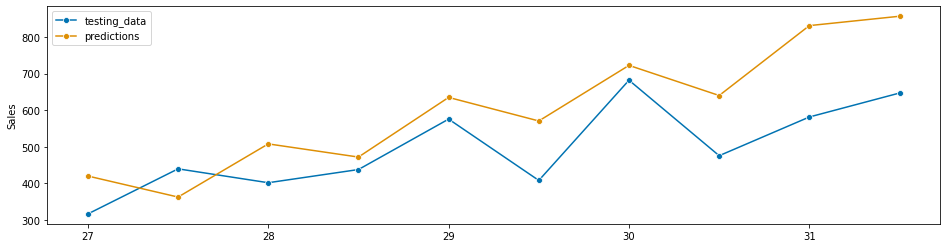

In [57]:
ps(y_test,pred,labels=['testing_data', 'predictions']);

Now you know about these magnificent libraries, may go and tell the Gospel.